# Inference about effect sizes (IN PROGRESS)
This notebook is going to explore any mistaken research conclusions that may arise from use of the original Rachlin discount function, and compare that to the Modified Rachlin function.

We will do this in the context of comparing two groups with different discount rates, $\kappa$. We will explore a range of true effect sizes (difference in means of 2 groups divided by pooled variance). The groups will have no systematic differences in $s$, but we do explore the effects of different levels of variability of $s$.

Note: for this work we focus on the simplified (best) case scenario where there is no measurement error in participant parameter values. We want to seperate issues of parameter recovery from reliability of research conclusion issues. Therefore these results represent the best case scenario.

**The example below is with differences in group $\kappa$ values, but no group difference in group $s$ values.**

That the Bayesian t-test component of this code was inspired by the PyMC3 implementation (here https://github.com/strawlab/best, https://docs.pymc.io/notebooks/BEST.html) of the BEST model by Kruschke (2012).

In [36]:
# useful for when updating external .py files
%load_ext autoreload
%autoreload 2

In [37]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
import math
import pandas as pd

import pymc3 as pm
print(f'PyMC3 v{pm.__version__}')

%run set_plot_options.py
from bayesian_t_test import make_unequal_variance_model

PyMC3 v3.7


In [2]:
# Initialize random number generator
SEED = 123
np.random.seed(SEED)

# Define sampler options
sample_options = {'tune': 1000, 'draws': 2000,
                  'chains': 4, 'cores': 4,
                  'nuts_kwargs': {'target_accept': 0.95},
                  'random_seed': SEED}

## Functions for simulated dataset generation

In [8]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [9]:
def make_dataset(group_logκstd,
                 groupA_logκmean=np.log(10**-1), 
                 groupB_logκmean=np.log(10**-2),
                 groupA_logsmean=0., 
                 groupB_logsmean=0.,
                 logs_std=0.1,
                 N_per_group=10):
    '''Generate a set of true participant discount function parameter
    values which conforms to the inputs:
    - group means
    - effect size'''
    
    # generate log(κ) values
    a_logκ = np.random.normal(loc=groupA_logκmean, scale=group_logκstd, size=N_per_group)
    b_logκ = np.random.normal(loc=groupB_logκmean, scale=group_logκstd, size=N_per_group)
    
    # generate log(s) values
    a_logs = np.random.normal(loc=groupA_logsmean, scale=logs_std, size=N_per_group)
    b_logs = np.random.normal(loc=groupB_logsmean, scale=logs_std, size=N_per_group)
    
    # put everything into a dataframe
    dataset = pd.DataFrame()
    dataset['logkappa'] = np.concatenate([a_logκ, b_logκ])
    dataset['logs'] = np.concatenate([a_logs, b_logs])
    dataset['group'] = np.concatenate( (np.zeros(N_per_group), np.ones(N_per_group)))
    # convert to int
    dataset['group'] = np.int_(dataset['group'])
    
    # generate log(k) values, ie k from the original Rachlin discount function. 
    # k = kappa^s
    dataset['logk'] = np.log( np.exp(dataset['logkappa'])**np.exp(dataset['logs']) )
    
    true_logκ_effect_size = cohend(a_logκ, b_logκ)
    true_logs_effect_size = cohend(a_logs, b_logs)
    
    return dataset, true_logκ_effect_size, true_logs_effect_size

Demonstration of the dataset generation.

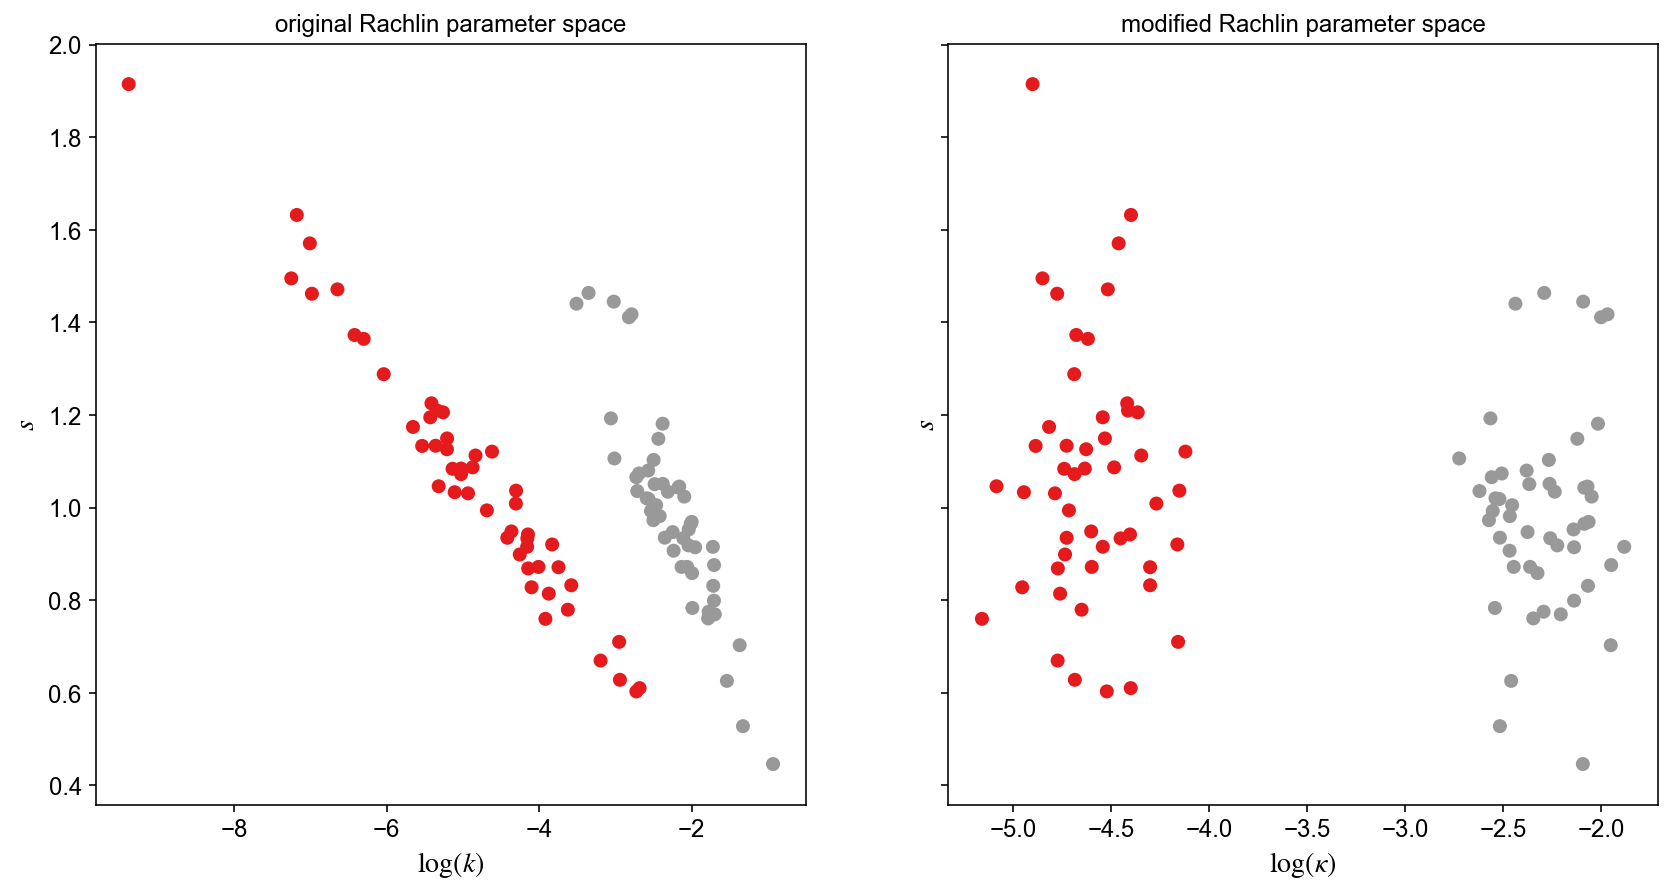

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

logκ_std = 0.2

dataset, true_logκ_effect_size, true_logs_effect_size = make_dataset(logκ_std,
                 groupA_logκmean=-4.6, 
                 groupB_logκmean=-2.3,
                 groupA_logsmean=0., 
                 groupB_logsmean=0.,
                 logs_std=0.25,
                 N_per_group=50)

# plot (kappa, s)
ax[1].scatter(dataset['logkappa'], np.exp(dataset['logs']), c=dataset['group'], cmap='Set1')
ax[1].set(xlabel='$\log(\kappa)$', ylabel='$s$', title='modified Rachlin parameter space')

# plot (k, s)
ax[0].scatter(dataset['logk'], np.exp(dataset['logs']), c=dataset['group'], cmap='Set1')
ax[0].set(xlabel='$\log(k)$', ylabel='$s$', title='original Rachlin parameter space');

To summarise, we are creating a distribution of $(\log(\kappa), \log(s))$ values (for 2 groups) in the modified Rachlin parameter space. We are then transforming these into the original Rachlin parameter space $(\log(k), \log(s))$.

We will then proceed to run Bayesian t-tests (unequal variances) on first $\log(\kappa)$ and then on $\log(k)$. This will give us the true effect size (in $\log(\kappa)$) as well as the inferred effect sizes (both for $\log(\kappa)$ and $\log(k)$).

## Sanity check: for a given `group_logκstd` level.

This section is sanity check code, it is not crucial to what comes below.

In [14]:
group_logκstd = 4

pdataset, true_logκ_effect_size, true_logs_effect_size = make_dataset(group_logκstd,
                                       groupA_logκmean=np.log(10**-1), 
                                       groupB_logκmean=np.log(10**-2),
                                       groupA_logsmean=0, 
                                       groupB_logsmean=0,
                                       logs_std=1,
                                       N_per_group=20)

In [15]:
model = make_unequal_variance_model(pdataset, target_variable='logkappa')

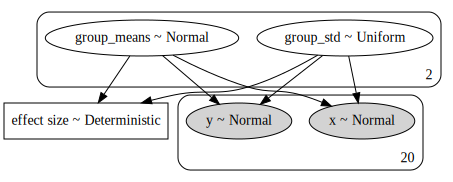

In [16]:
pm.model_to_graphviz(model)

In [17]:
# DO THE INFERENCE
with model:
    trace = pm.sample(**sample_options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4773.04draws/s]


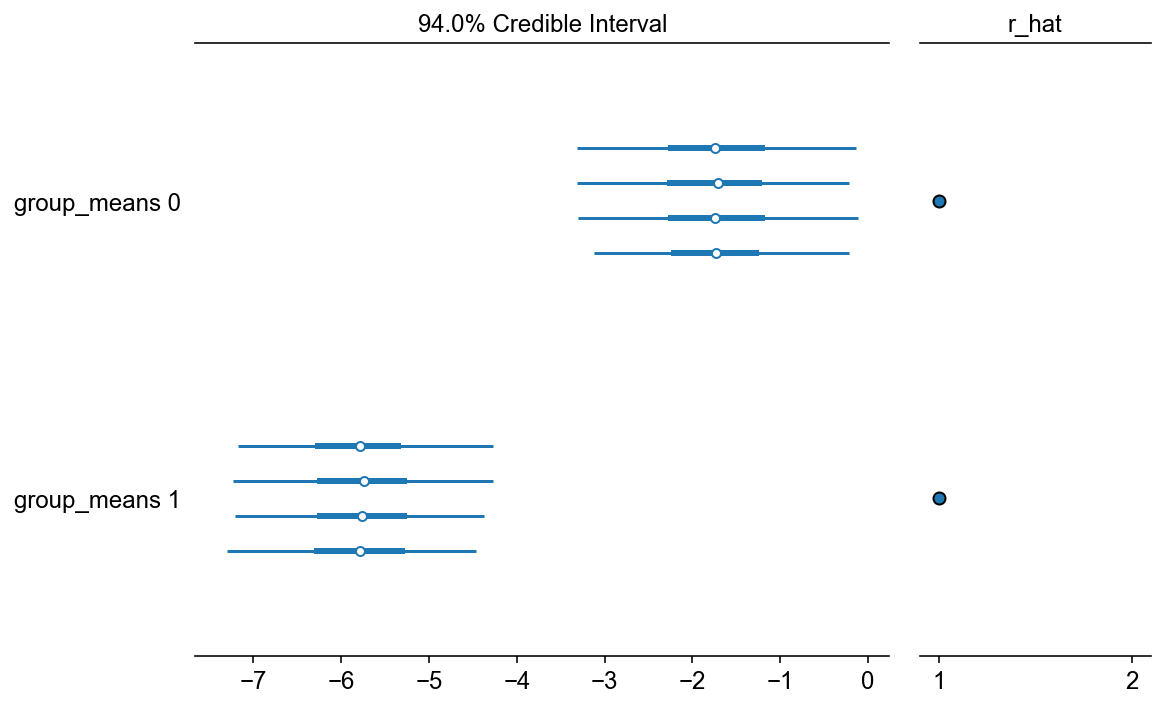

In [18]:
pm.forestplot(trace, var_names=['group_means'], r_hat=True);

In [19]:
true_logκ_effect_size

1.2329293817808005

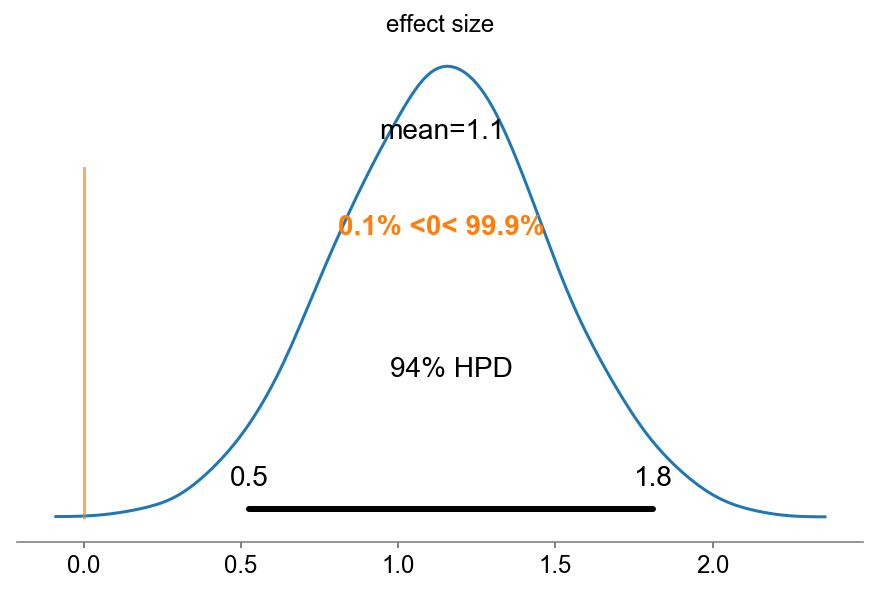

In [20]:
pm.plot_posterior(trace, var_names=['effect size'], ref_val=0, color='#87ceeb');

In [21]:
es_quantiles = pm.stats.quantiles(trace['effect size'])
es_quantiles

{2.5: 0.47379770984431013,
 25: 0.9097053628073021,
 50: 1.1389036179315593,
 75: 1.3632458514393142,
 97.5: 1.8120302984815335}

In [22]:
# print(f'True effect size: {})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3216.39draws/s]


{2.5: -0.1913101413390104,
 25: 0.19827853926089994,
 50: 0.39388117087413343,
 75: 0.5921722762824885,
 97.5: 0.9728062138380459}

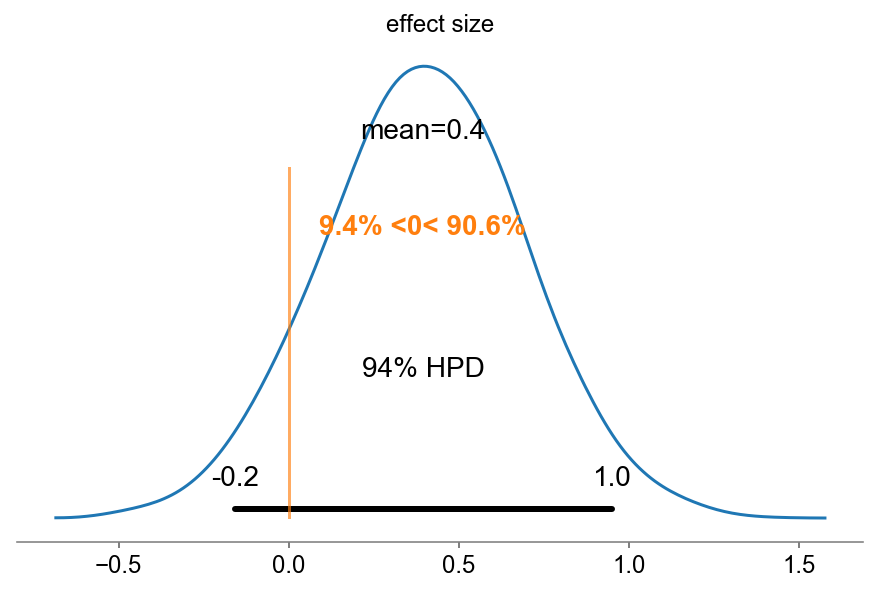

In [23]:
model = make_model(pdataset, target_variable='logk')

# DO THE INFERENCE
with model:
    trace = pm.sample(**sample_options)
    
pm.plot_posterior(trace, var_names=['effect size'], ref_val=0, color='#87ceeb');

es_quantiles = pm.stats.quantiles(trace['effect size'])
es_quantiles

## Example 1 - run a sweep over effect sizes
This is our objective - we want to iterate over true effect sizes and plot the inferred effect sizes, for both $\log(\kappa)$ and $\log(k)$.

First we define some functions to do this and plot the results.

In [24]:
def run_effect_size_sweep(group_κstd_list, **data_kwargs):

    logκ_true_effect_size = []

    logκ_inferred_effect_size_median = []
    logκ_inferred_effect_size_lower = []
    logκ_inferred_effect_size_upper = []

    k_inferred_effect_size_median = []
    k_inferred_effect_size_lower = []
    k_inferred_effect_size_upper = []
    

    for group_logκstd in group_κstd_list:

        print(f'group_logκstd = {group_logκstd}')

        pdataset, true_logκ_es, true_logs_es = make_dataset(group_logκstd, **data_kwargs)

        # inferences about effect size of kappa ----------------

        model_kappa = make_unequal_variance_model(pdataset, target_variable='logkappa')

        with model_kappa:
            trace = pm.sample(**sample_options)

        es_quantiles = pm.stats.quantiles(trace['effect size'])

        logκ_true_effect_size.append(true_logκ_es)
        logκ_inferred_effect_size_median.append(es_quantiles[50])
        logκ_inferred_effect_size_lower.append(es_quantiles[2.5])
        logκ_inferred_effect_size_upper.append(es_quantiles[97.5])


        # inferences about effect size of k --------------------

        model_k = make_model(pdataset, target_variable='logk')

        with model_k:
            trace = pm.sample(**sample_options)

        es_quantiles = pm.stats.quantiles(trace['effect size'])

        k_inferred_effect_size_median.append(es_quantiles[50])
        k_inferred_effect_size_lower.append(es_quantiles[2.5])
        k_inferred_effect_size_upper.append(es_quantiles[97.5])


    results = {'logκ': {'true': np.array(logκ_true_effect_size), 
                        'median': np.array(logκ_inferred_effect_size_median), 
                        'lower': np.array(logκ_inferred_effect_size_lower), 
                        'upper':np.array(logκ_inferred_effect_size_upper)},
               'k': {'median': np.array(k_inferred_effect_size_median), 
                     'lower': np.array(k_inferred_effect_size_lower), 
                     'upper':np.array(k_inferred_effect_size_upper)}}
    
    return results


def plot_results(results, ax):
    
    plt.rcParams.update({'font.size': 16})

    # LOG KAPPA PLOT ------------------------------------------------
    ax.errorbar(results['logκ']['true'],
                results['logκ']['median'], 
                yerr=[results['logκ']['lower'] - results['logκ']['median'],
                      results['logκ']['median'] - results['logκ']['upper']], 
                   fmt='-o', 
                   label='modified Rachlin')

    ax.errorbar(results['logκ']['true'],
                results['k']['median'], 
                yerr=[results['k']['lower'] - results['k']['median'],
                      results['k']['median'] - results['k']['upper']], 
                   fmt='-o', 
                   label='original Rachlin')

    ax.legend()

    ax.axhline(y=0, linewidth=1.5, c='k', ls='--')

    max_effect_size = 3
    ax.plot([0, max_effect_size], [0, max_effect_size], c='k')

    ax.set(xlabel="True empirical effect size, Cohen's D", 
           ylabel="Inferred effect size, Cohen's D", 
           title='log(κ)', ylim=[-1, max_effect_size]);

Now we actually run some sweeps over effect size and plot the results.

We do this multiple times, for different degrees of variation in $s$.

In [31]:
# COMPUTE 

group_κstd_list = np.linspace(1, 10, 7)


# simulation 1 - lowish variability in s ----------------------------

data_kwargs = {'groupA_logκmean': np.log(10**-1),
               'groupB_logκmean': np.log(10**-2),
               'groupA_logsmean': 0,
               'groupB_logsmean': 0,
               'logs_std': 0.25,
               'N_per_group': 40}
    
results0 = run_effect_size_sweep(group_κstd_list, **data_kwargs)


# simulation 2 - highish variability in s ----------------------------

data_kwargs = {'groupA_logκmean': np.log(10**-1),
               'groupB_logκmean': np.log(10**-2),
               'groupA_logsmean': 0,
               'groupB_logsmean': 0,
               'logs_std': 0.5,
               'N_per_group': 40}
    
results1 = run_effect_size_sweep(group_κstd_list, **data_kwargs)


# simulation 3 - highish variability in s ----------------------------

data_kwargs = {'groupA_logκmean': np.log(10**-1),
               'groupB_logκmean': np.log(10**-2),
               'groupA_logsmean': 0,
               'groupB_logsmean': 0,
               'logs_std': 1,
               'N_per_group': 40}
    
results2 = run_effect_size_sweep(group_κstd_list, **data_kwargs)

group_logκstd = 1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4825.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4769.28draws/s]


group_logκstd = 2.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4753.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4768.69draws/s]


group_logκstd = 4.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4812.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4702.81draws/s]


group_logκstd = 5.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4565.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4658.96draws/s]


group_logκstd = 7.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4323.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3714.55draws/s]


group_logκstd = 8.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3250.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3088.16draws/s]


group_logκstd = 10.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 2683.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3074.59draws/s]


group_logκstd = 1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4448.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4677.76draws/s]


group_logκstd = 2.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4621.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4555.76draws/s]


group_logκstd = 4.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4652.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4580.68draws/s]


group_logκstd = 5.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4400.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3368.49draws/s]


group_logκstd = 7.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4082.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3348.46draws/s]


group_logκstd = 8.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3265.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:04<00:00, 2941.21draws/s]
The acceptance probability does not match the target. It is 0.8860482597569542, but should be close to 0.95. Try to increase the number of tuning steps.


group_logκstd = 10.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3178.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3486.54draws/s]


group_logκstd = 1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4715.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3413.98draws/s]


group_logκstd = 2.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4724.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3189.48draws/s]
The acceptance probability does not match the target. It is 0.9047247979885048, but should be close to 0.95. Try to increase the number of tuning steps.


group_logκstd = 4.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4794.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3120.53draws/s]


group_logκstd = 5.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4606.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3138.49draws/s]


group_logκstd = 7.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4308.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3346.82draws/s]


group_logκstd = 8.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3298.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3693.98draws/s]


group_logκstd = 10.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3184.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3836.88draws/s]


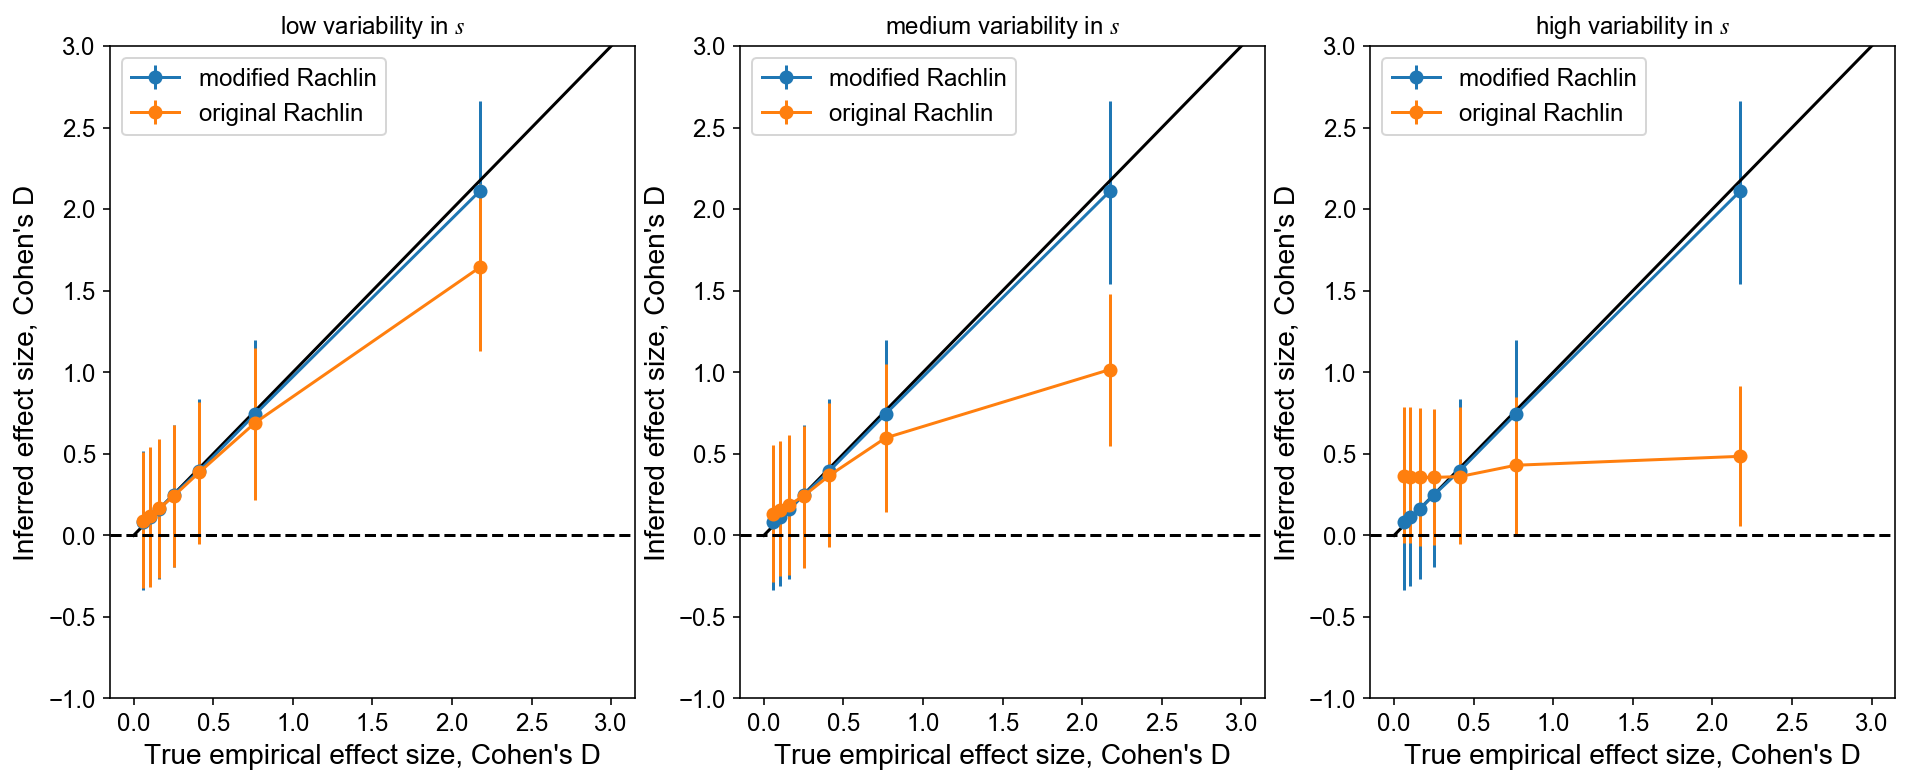

In [35]:
# PLOT

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

plot_results(results0, ax[0])
ax[0].set_title('low variability in $s$')

plot_results(results1, ax[1])
ax[1].set_title('medium variability in $s$');

plot_results(results2, ax[2])
ax[2].set_title('high variability in $s$');

The inferred effect size for the modified Rachlin function is always good.

The accuracy of the inferred effect size for the original Rachlin function depends upon how much variability in $s$ there is. When the variability is low then the inferences are not too bad. But when the variability in $s$ is high, then the inferred effect sizes are quite bad.

## Example 2 - group differences in $s$, but not $\kappa$
If we use the traditional Rachlin function, then if there are no group differences in discounting ($\kappa$) but there are group differences in $s$, then we could erroneously conclude that there are differences in discounting (via $k$) when there are not.

# References
- Kruschke, John. (2012) Bayesian estimation supersedes the t test. Journal of Experimental Psychology: General.